In [1]:
import os

RUNNING_IN_KAGGLE = 'KAGGLE_URL_BASE' in os.environ

if RUNNING_IN_KAGGLE:
    DATA_PATH = '/kaggle/input/mars-for-students-cleaned-fixed'
else:
    DATA_PATH = './data/'


In [2]:
DATA_PATH

'./data/'

In [3]:
import numpy as np
import pandas as pd
from datetime import datetime

import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

from sklearn.decomposition import PCA
from sklearn.cluster import KMeans

import matplotlib.pyplot as plt
%matplotlib inline

np.random.seed(42)
tf.random.set_seed(42)

print(f"TensorFlow version: {tf.__version__}")
print(f"Keras version: {tfk.__version__}")
print(f"GPU devices: {len(tf.config.list_physical_devices('GPU'))}")

TensorFlow version: 2.18.0
Keras version: 3.7.0
GPU devices: 0


In [4]:
# Set seed for reproducibility
seed = 42

# Import necessary libraries
import os

# Set environment variables before importing modules
os.environ['TF_CPP_MIN_LOG_LEVEL'] = '3'
os.environ['PYTHONHASHSEED'] = str(seed)
os.environ['MPLCONFIGDIR'] = os.getcwd() + '/configs/'

# Suppress warnings
import warnings
warnings.simplefilter(action='ignore', category=FutureWarning)
warnings.simplefilter(action='ignore', category=Warning)

# Import necessary modules
import logging
import random
import numpy as np

# Set seeds for random number generators in NumPy and Python
np.random.seed(seed)
random.seed(seed)

# Import TensorFlow and Keras
import tensorflow as tf
from tensorflow import keras as tfk
from tensorflow.keras import layers as tfkl

# Set seed for TensorFlow
tf.random.set_seed(seed)
tf.compat.v1.set_random_seed(seed)

# Reduce TensorFlow verbosity
tf.autograph.set_verbosity(0)
tf.get_logger().setLevel(logging.ERROR)
tf.compat.v1.logging.set_verbosity(tf.compat.v1.logging.ERROR)

# Print TensorFlow version
print(tf.__version__)

# Import other libraries
import os
import math
from PIL import Image
from keras import backend as K
from sklearn.model_selection import train_test_split
from sklearn.metrics import accuracy_score, f1_score, precision_score, recall_score
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import matplotlib.pyplot as plt
import seaborn as sns

# Configure plot display settings
sns.set(font_scale=1.4)
sns.set_style('white')
plt.rc('font', size=14)
%matplotlib inline


2.18.0


In [5]:
data = os.path.join(DATA_PATH, "mars_for_students_cleaned_fixed.npz")
data = np.load(data)

X_train_val = data["training_img"]
y_train_val = data["training_masks"]

X_test = data["test_set"]

print(f"Training X shape: {X_train_val.shape}")
print(f"Training y shape: {y_train_val.shape}")
print(f"Test X shape: {X_test.shape}")

Training X shape: (2505, 64, 128)
Training y shape: (2505, 64, 128)
Test X shape: (10022, 64, 128)


In [ ]:
# Set batch size for training
BATCH_SIZE = 32 # HERE I CHANGED FROM 64

# Set learning rate for the optimiser
LEARNING_RATE = 1e-3

# Set early stopping patience threshold
PATIENCE = 30

# Set maximum number of training epochs
EPOCHS = 1000

# Set data split size for training and validation
SPLITS_SIZE = 300

In [7]:
# Add color channel and rescale pixels between 0 and 1
X_train_val = X_train_val[..., np.newaxis] / 255.0
y_train_val = y_train_val[..., np.newaxis]
X_test = X_test[..., np.newaxis] / 255.0

X_train, X_val, y_train, y_val = train_test_split(X_train_val, y_train_val, test_size=SPLITS_SIZE, random_state=seed )


input_shape = X_train.shape[1:]
num_classes = len(np.unique(y_train))

print(f"Input shape: {input_shape}")
print(f"mask shape: {y_train.shape[1:]}")
print(f"Number of classes: {num_classes}")

Input shape: (64, 128, 1)
mask shape: (64, 128, 1)
Number of classes: 5


In [8]:
label_name = {0: "Background",
    1: "Soil",
    2: "Bedrock",
    3: "Sand",
    4: "Big Rock"
    }

In [9]:
'''geometrical transformations must be specified on both images and labels,
thus it is much easier to apply them separately and them feed the already
augmented versions.
ALSO LABELS MUST BE AUGMENTED!'''

@tf.function
def random_flip(image, label, seed=None):
    """Consistent random horizontal flip."""
    if seed is None:
        seed = np.random.randint(0, 1000000)
    flip_prob = tf.random.uniform([], seed=seed)
    image = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(image),
        lambda: image
    )
    label = tf.cond(
        flip_prob > 0.5,
        lambda: tf.image.flip_left_right(label),
        lambda: label
    )
    return image, label

In [10]:
def make_dataset(X, y, batch_size, shuffle=True, augment=False, seed=None):
    """
    Create a memory-efficient TensorFlow dataset.
    """
    # Create dataset from file paths
    dataset = tf.data.Dataset.from_tensor_slices((X_train, y_train))

    if shuffle:
        dataset = dataset.shuffle(buffer_size=batch_size * 2, seed=seed)

    if augment:
        dataset = dataset.map(
            lambda x, y: random_flip(x, y, seed=seed),
            num_parallel_calls=tf.data.AUTOTUNE
        )

    # Batch the data
    dataset = dataset.batch(batch_size, drop_remainder=False)
    dataset = dataset.prefetch(tf.data.AUTOTUNE) #speedup, prec arica le immagine

    return dataset

In [11]:
# Create the datasets
print("Creating datasets...")
train_dataset = make_dataset(
    X_train, y_train,
    batch_size=BATCH_SIZE,
    shuffle=True,
    augment=False,
    seed=seed
)

val_dataset = make_dataset(
    X_val, y_val,
    batch_size=BATCH_SIZE,
    shuffle=False
)


print("Datasets created!")

# Check the shape of the data
for images, labels in train_dataset.take(1):
    input_shape = images.shape[1:]
    print(f"\nInput shape: {input_shape}")
    print("Images shape:", images.shape)
    print("Labels shape:", labels.shape)
    print("Labels dtype:", labels.dtype)
    break

Creating datasets...
Datasets created!

Input shape: (64, 128, 1)
Images shape: (32, 64, 128, 1)
Labels shape: (32, 64, 128, 1)
Labels dtype: <dtype: 'float64'>


Visualizing examples from the training set:


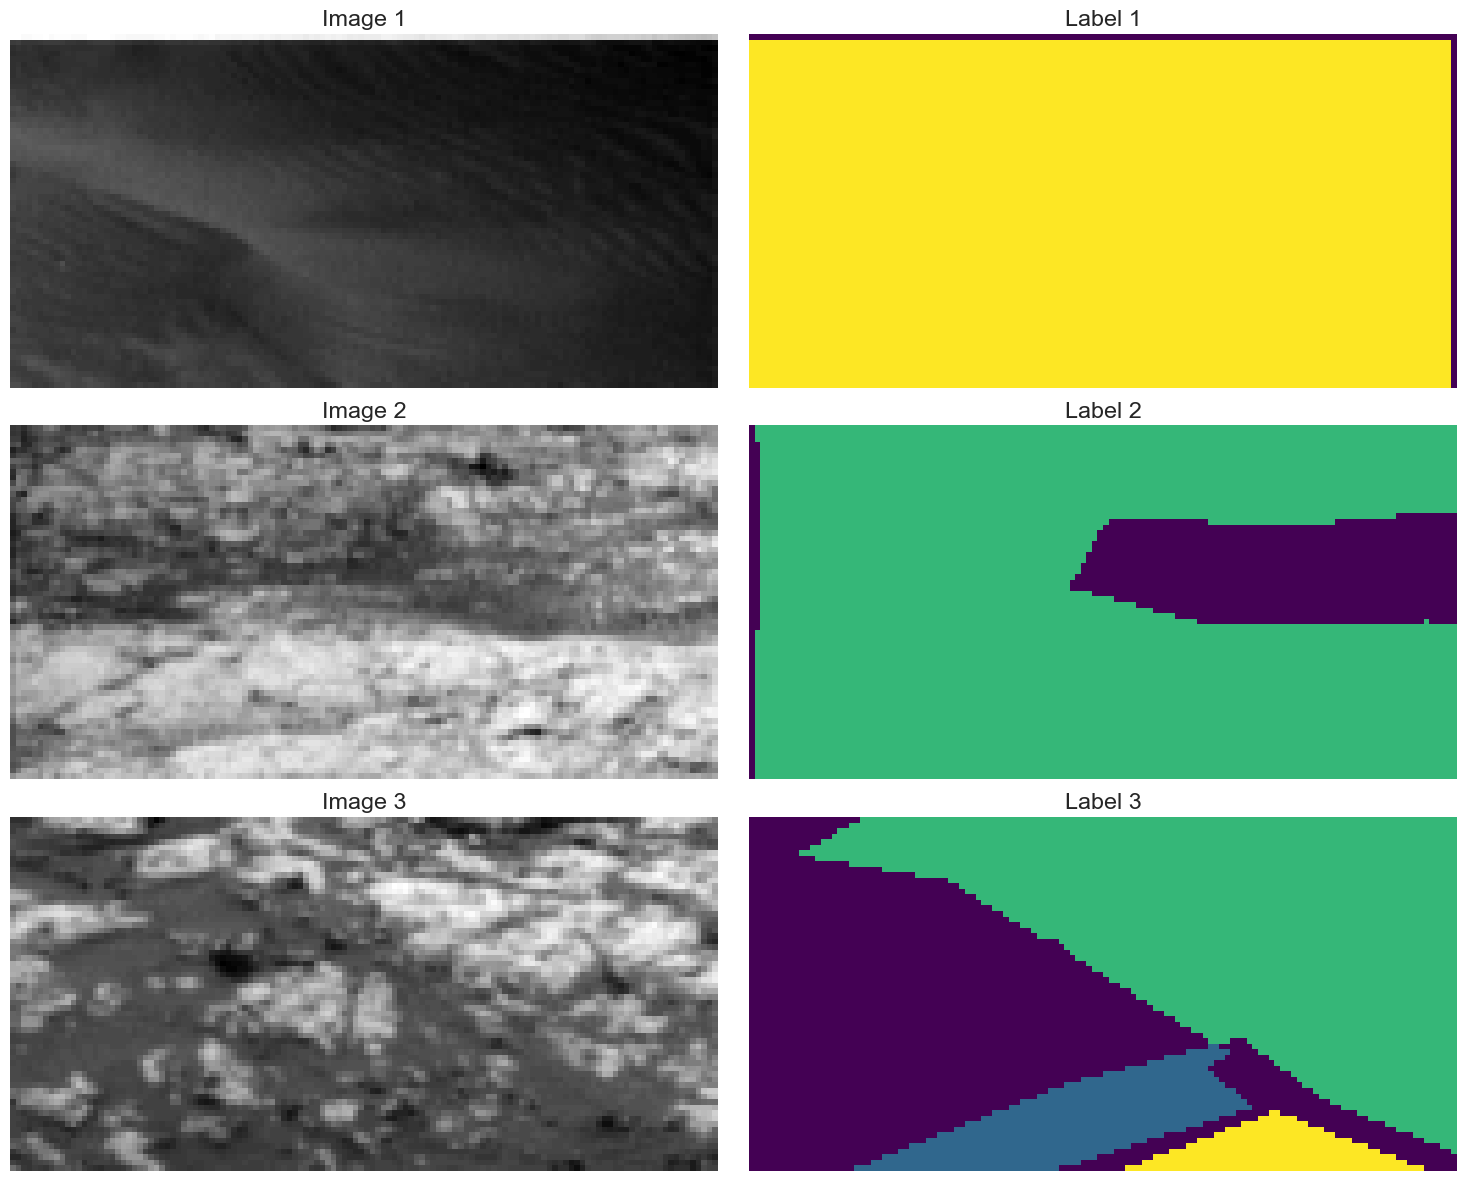

In [12]:
def create_segmentation_colormap(num_classes):
    """
    Create a linear colormap using a predefined palette.
    Uses 'viridis' as default because it is perceptually uniform
    and works well for colorblindness.
    """
    return plt.cm.viridis(np.linspace(0, 1, num_classes))

def apply_colormap(label, colormap=None):
    """
    Apply the colormap to a label.
    """
    # Ensure label is 2D
    label = np.squeeze(label)

    if colormap is None:
        num_classes = len(np.unique(label))
        colormap = create_segmentation_colormap(num_classes)

    # Apply the colormap
    colored = colormap[label.astype(int)]

    return colored

def plot_sample_batch(dataset, num_samples=3):
    """
    Display some image and label pairs from the dataset.
    """
    plt.figure(figsize=(15, 4*num_samples))

    for images, labels in dataset.take(1):
        labels_np = labels.numpy()
        num_classes = len(np.unique(labels_np))
        colormap = create_segmentation_colormap(num_classes)

        for j in range(min(num_samples, len(images))):
            # Plot original image
            plt.subplot(num_samples, 2, j*2 + 1)
            plt.imshow(images[j], cmap='gray')
            plt.title(f'Image {j+1}')
            plt.axis('off')

            # Plot colored label
            plt.subplot(num_samples, 2, j*2 + 2)
            colored_label = apply_colormap(labels_np[j], colormap)
            plt.imshow(colored_label)
            plt.title(f'Label {j+1}')
            plt.axis('off')

    plt.tight_layout()
    plt.show()
    plt.close()

# Visualize examples from the training set
print("Visualizing examples from the training set:")
plot_sample_batch(train_dataset, num_samples=3)

### Base blocks

In [70]:
def unet_block(input_tensor, 
               filters, 
               kernel_size=3, 
               activation='relu', 
               dropout_rate=0.2, 
               stack=2, 
               normalization='batch', 
               name=''):
    x = input_tensor
    for i in range(stack):
        x = tfkl.Conv2D(filters, kernel_size=kernel_size, padding='same', name=name + 'conv' + str(i + 1))(x)
        if normalization == 'instance':
            x = tfkl.UnitNormalization(name=name + 'bn' + str(i + 1))(x)
        elif normalization == 'layer':
            x = tfkl.LayerNormalization(name=name + 'bn' + str(i + 1))(x)
        elif normalization == 'group':
            x = tfkl.GroupNormalization(name=name + 'bn' + str(i + 1))(x)
        else:
            x = tfkl.BatchNormalization(name=name + 'bn' + str(i + 1))(x)
        x = tfkl.Activation(activation, name=name + 'activation' + str(i + 1))(x)
    return x
    # Return the transformed tensor
    return x

def conv_block(input_tensor, num_filters, kernel_size=3, activation='relu', name=''):
    x = tfkl.Conv2D(num_filters, kernel_size=kernel_size, padding='same', name=name + 'conv1')(input_tensor)
    x = tfkl.BatchNormalization(name=name + 'bn1')(x)
    x = tfkl.Activation(activation, name=name + 'activation1')(x)
    x = tfkl.Conv2D(num_filters, kernel_size=kernel_size, padding='same', name=name + 'conv2')(x)
    x = tfkl.BatchNormalization(name=name + 'bn2')(x)
    x = tfkl.Activation(activation, name=name + 'activation2')(x)
    return x



### Attention blocks

In [71]:
# attention blocks

def se_block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    
    se = tfkl.GlobalAveragePooling2D()(input_tensor)
    se = tfkl.Reshape(se_shape)(se)
    se = tfkl.Dense(filters // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = tfkl.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = tfkl.multiply([input_tensor, se])
    return x

def attention_gate(x, g, inter_shape):
    theta_x = tfkl.Conv2D(inter_shape, (1, 1), strides=(1, 1), padding='same')(x)
    phi_g = tfkl.Conv2D(inter_shape, (1, 1), padding='same')(g)
    
    # Ridimensiona phi_g per avere le stesse dimensioni spaziali di theta_x
    phi_g = tfkl.UpSampling2D(size=(x.shape[1] // g.shape[1], x.shape[2] // g.shape[2]))(phi_g)
    
    add_xg = tfkl.add([theta_x, phi_g])
    relu_xg = tfkl.Activation('relu')(add_xg)
    
    psi = tfkl.Conv2D(1, (1, 1), padding='same')(relu_xg)
    sigmoid_xg = tfkl.Activation('sigmoid')(psi)
    
    # Ridimensiona sigmoid_xg per avere le stesse dimensioni spaziali di x
    upsample_psi = tfkl.UpSampling2D(size=(x.shape[1] // sigmoid_xg.shape[1], x.shape[2] // sigmoid_xg.shape[2]))(sigmoid_xg)
    upsample_psi = tfkl.Lambda(lambda x, repnum: tf.keras.backend.repeat_elements(x, repnum, axis=3), arguments={'repnum': x.shape[3]})(upsample_psi)
    
    y = tfkl.multiply([upsample_psi, x])
    result = tfkl.Conv2D(x.shape[3], (1, 1), padding='same')(y)
    result_bn = tfkl.BatchNormalization()(result)
    
    return result_bn


def gating_signal(input_tensor, filters, kernel_size=(1, 1), strides=(1, 1), padding='same'):
    x = tfkl.Conv2D(filters, kernel_size, strides=strides, padding=padding)(input_tensor)
    x = tfkl.BatchNormalization()(x)
    x = tfkl.Activation('relu')(x)
    return x



In [72]:
class GlobalContextModule(tfkl.Layer):
    def __init__(self, filters, **kwargs):
        super(GlobalContextModule, self).__init__(**kwargs)
        self.conv1 = tfkl.Conv2D(filters, (1, 1))
        self.conv2 = tfkl.Conv2D(filters, (1, 1))
        self.conv3 = tfkl.Conv2D(filters, (1, 1))
        self.layer_norm = tfkl.LayerNormalization()
        self.relu = tfkl.ReLU()
        self.sigmoid = tf.keras.activations.sigmoid

    def call(self, inputs):
        # Global attention pooling
        attention_weights = tfkl.Softmax(axis=(1, 2))(self.conv1(inputs))
        global_context = tf.reduce_sum(attention_weights * inputs, axis=(1, 2), keepdims=True)
        
        # Bottleneck transform
        transformed = self.relu(self.layer_norm(self.conv2(global_context)))
        transformed = self.sigmoid(self.conv3(transformed))
        
        # Feature fusion
        return inputs + inputs * transformed


In [73]:
class CascadeAttentiveDropout(tfkl.Layer):
    def __init__(self, lambda_channel=0.8, lambda_spatial=0.8, **kwargs):
        super(CascadeAttentiveDropout, self).__init__(**kwargs)
        self.lambda_channel = lambda_channel
        self.lambda_spatial = lambda_spatial

    def call(self, inputs):
        # Channel-Dropout
        channel_avg = tf.reduce_mean(inputs, axis=(1, 2), keepdims=True)
        max_channel = tf.reduce_max(channel_avg, axis=-1, keepdims=True)
        channel_mask = tf.cast(channel_avg < (max_channel * self.lambda_channel), tf.float32)
        channel_dropped = inputs * channel_mask

        # Spatial-Dropout
        spatial_avg = tf.reduce_mean(inputs, axis=-1, keepdims=True)
        max_spatial = tf.reduce_max(spatial_avg, axis=(1, 2), keepdims=True)
        spatial_mask = tf.cast(spatial_avg < (max_spatial * self.lambda_spatial), tf.float32)
        return channel_dropped * spatial_mask


In [77]:
def get_unet_model(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
    tf.random.set_seed(seed)
    input_layer = tfkl.Input(shape=input_shape, name='input_layer')

    # Downsampling path
    down_block_1 = unet_block(input_layer, 32, name='down_block1_')
    d1 = tfkl.MaxPooling2D()(down_block_1)

    down_block_2 = unet_block(d1, 64, name='down_block2_')
    d2 = tfkl.MaxPooling2D()(down_block_2)

    # Bottleneck
    bottleneck = unet_block(d2, 128, name='bottleneck')

    # Upsampling path
    u1 = tfkl.UpSampling2D()(bottleneck)
    u1 = tfkl.Concatenate()([u1, down_block_2])
    u1 = unet_block(u1, 64, name='up_block1_')

    u2 = tfkl.UpSampling2D()(u1)
    u2 = tfkl.Concatenate()([u2, down_block_1])
    u2 = unet_block(u2, 32, name='up_block2_')

    # Output Layer
    output_layer = tfkl.Conv2D(num_classes, kernel_size=1, padding='same', activation="softmax", name='output_layer')(u2)

    model = tf.keras.Model(inputs=input_layer, outputs=output_layer, name='UNet')
    return model

def get_deep_unet_model(input_shape=(64, 128, 1), num_classes=5, seed=42):
    tf.random.set_seed(seed)

    inputs = tfkl.Input(shape=input_shape)
    
    # Encoder
    c1 = unet_block(inputs, 64, name='enc1_')
    p1 = tfkl.MaxPooling2D((2, 2))(c1)
    p1 = se_block(p1)


    c2 = unet_block(p1, 128, name='enc2_')
    p2 = tfkl.MaxPooling2D((2, 2))(c2)
    p2 = se_block(p2)


    c3 = unet_block(p2, 256, name='enc3_')
    p3 = tfkl.MaxPooling2D((2, 2))(c3)
    p3 = se_block(p3)


    # c4 = unet_block(p3, 512, name='enc4_')
    # p4 = tfkl.MaxPooling2D((2, 2))(c4)
    
    # Bottleneck
    bn = unet_block(p3, 512, name='bn_')
    bn = GlobalContextModule(512)(bn)
    bn = CascadeAttentiveDropout()(bn)
    
    # Decoder with Attention Gates
    # g4 = gating_signal(bn, 512)
    # a4 = attention_gate(c4, g4, 512)
    # u4 = tfkl.Conv2DTranspose(512, (2, 2), strides=(2, 2), padding='same')(bn)
    # u4 = tfkl.concatenate([u4, a4])
    # c5 = unet_block(u4, 512, name='dec4_')
    
    g3 = gating_signal(bn, 256)
    a3 = attention_gate(c3, g3, 256)
    u3 = tfkl.Conv2DTranspose(256, (2, 2), strides=(2, 2), padding='same')(bn)
    u3 = tfkl.concatenate([u3, a3])
    u3 = se_block(u3)
    c6 = unet_block(u3, 256, name='dec3_')
    
    g2 = gating_signal(c6, 128)
    a2 = attention_gate(c2, g2, 128)
    u2 = tfkl.Conv2DTranspose(128, (2, 2), strides=(2, 2), padding='same')(c6)
    u2 = tfkl.concatenate([u2, a2])
    u2 = se_block(u2)
    c7 = unet_block(u2, 128, name='dec2_')
    
    g1 = gating_signal(c7, 64)
    a1 = attention_gate(c1, g1, 64)
    u1 = tfkl.Conv2DTranspose(64, (2, 2), strides=(2, 2), padding='same')(c7)
    u1 = tfkl.concatenate([u1, a1])
    u1 = se_block(u1)
    c8 = unet_block(u1, 64, name='dec1_')
    
    outputs = tfkl.Conv2D(num_classes, (1, 1), activation='softmax')(c8)
    
    model = tf.keras.Model(inputs=[inputs], outputs=[outputs])
    return model


In [78]:
# def get_fusion_unet(input_shape=(64, 128, 1), num_classes=num_classes, seed=seed):
#     tf.random.set_seed(seed)
    
#     # Due U-Net separate
#     unet1 = get_deep_unet_model()
#     unet2 = get_deep_unet_model()
    
#     # Input condiviso
#     inputs = tfkl.Input(shape=input_shape, name='input')
    
#     # Uscite delle due U-Net
#     unet1_output = unet1(inputs)
#     unet2_output = unet2(inputs)
    
#     # Fusione delle caratteristiche
#     fused = tfkl.Concatenate(axis=-1)([unet1_output, unet2_output])
#     fused = tfkl.Conv2D(num_classes, (1, 1), activation='softmax', name='fused_output')(fused)
    
#     model = tf.keras.Model(inputs=inputs, outputs=fused, name='fusion_unet')
#     return model

In [79]:
model = get_deep_unet_model()

# Print a detailed summary of the model with expanded nested layers and trainable parameters.
model.summary(expand_nested=True, show_trainable=True)

# Generate and display a graphical representation of the model architecture.
tf.keras.utils.plot_model(model, expand_nested=True, dpi=70)

Model: "functional_8"

┏━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━┳━━━━━━━━━━━━━━━━┳━━━━━━━┓
┃ Layer (type)      ┃ Output Shape    ┃   Param # ┃ Connected to   ┃ Trai… ┃
┡━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━╇━━━━━━━━━━━━━━━━╇━━━━━━━┩
│ input_layer_10    │ (None, 64, 128, │         0 │ -              │   -   │
│ (InputLayer)      │ 1)              │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv1        │ (None, 64, 128, │       640 │ input_layer_1… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_bn1          │ (None, 64, 128, │       256 │ enc1_conv1[0]… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_activation1  │ (None, 64, 128, │         0 │ enc1_bn1[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_conv2        │ (None, 64, 128, │    36,928 │ enc1_activati… │   Y   │
│ (Conv2D)          │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_bn2          │ (None, 64, 128, │       256 │ enc1_conv2[0]… │   Y   │
│ (BatchNormalizat… │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc1_activation2  │ (None, 64, 128, │         0 │ enc1_bn2[0][0] │   -   │
│ (Activation)      │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ max_pooling2d_29  │ (None, 32, 64,  │         0 │ enc1_activati… │   -   │
│ (MaxPooling2D)    │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ global_average_p… │ (None, 64)      │         0 │ max_pooling2d… │   -   │
│ (GlobalAveragePo… │                 │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ reshape_44        │ (None, 1, 1,    │         0 │ global_averag… │   -   │
│ (Reshape)         │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_84 (Dense)  │ (None, 1, 1, 4) │       256 │ reshape_44[0]… │   Y   │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ dense_85 (Dense)  │ (None, 1, 1,    │       256 │ dense_84[0][0] │   Y   │
│                   │ 64)             │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ multiply_69       │ (None, 32, 64,  │         0 │ max_pooling2d… │   -   │
│ (Multiply)        │ 64)             │           │ dense_85[0][0] │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv1        │ (None, 32, 64,  │    73,856 │ multiply_69[0… │   Y   │
│ (Conv2D)          │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_bn1          │ (None, 32, 64,  │       512 │ enc2_conv1[0]… │   Y   │
│ (BatchNormalizat… │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_activation1  │ (None, 32, 64,  │         0 │ enc2_bn1[0][0] │   -   │
│ (Activation)      │ 128)            │           │                │       │
├───────────────────┼─────────────────┼───────────┼────────────────┼───────┤
│ enc2_conv2        │ (None, 32, 64,  │   147,584 │ enc2_activati… │   Y   │
│ (Conv2D)          │ 128)            │           │                │     

 Total params: 8,986,376 (34.28 MB)

 Trainable params: 8,978,952 (34.25 MB)

 Non-trainable params: 7,424 (29.00 KB)

You must install pydot (`pip install pydot`) for `plot_model` to work.


In [80]:
# Define custom Mean Intersection Over Union metric
class MeanIntersectionOverUnion(tf.keras.metrics.MeanIoU):
    def __init__(self, num_classes, labels_to_exclude=None, name="mean_iou", dtype=None):
        super(MeanIntersectionOverUnion, self).__init__(num_classes=num_classes, name=name, dtype=dtype)
        if labels_to_exclude is None:
            labels_to_exclude = [0]  # Default to excluding label 0
        self.labels_to_exclude = labels_to_exclude

    def update_state(self, y_true, y_pred, sample_weight=None):
        # Convert predictions to class labels
        y_pred = tf.math.argmax(y_pred, axis=-1)

        # Flatten the tensors
        y_true = tf.reshape(y_true, [-1])
        y_pred = tf.reshape(y_pred, [-1])

        # Apply mask to exclude specified labels  ->IMPORTANT FOR HOMEWORK
        for label in self.labels_to_exclude:
            mask = tf.not_equal(y_true, label)
            y_true = tf.boolean_mask(y_true, mask)
            y_pred = tf.boolean_mask(y_pred, mask)

        # Update the state
        return super().update_state(y_true, y_pred, sample_weight)

# Visualization callback
class VizCallback(tf.keras.callbacks.Callback):
    def __init__(self, X_val, y_val,  frequency=5):
        super().__init__()
        self.X_val = X_val
        self.y_val = y_val
        self.num_classes = 5
        self.frequency = frequency
        self.print= False

    def on_epoch_end(self, epoch, logs=None):
        if epoch % self.frequency == 0:  # Visualize only every "frequency" epochs
            if self.print:
                print("X_val shape:", self.X_val.shape)
                print("y_val shape:", self.y_val.shape)

            image = self.X_val
            label = self.y_val
            if self.print:
                print("Images shape:", image.shape)
                print("Labels shape:", label.shape)
            
            image = tf.expand_dims(image, 0)
            pred = self.model.predict(image, verbose=0) #300x64x128x5 [0,1]
            y_pred = tf.math.argmax(pred, axis=-1) #300x64x128 [0,4]
            y_pred = y_pred.numpy() 

            if self.print:
                print("pred shape:", pred.shape)
                print("y_pred shape:", y_pred.shape)


            
            # Create colormap
            colormap = create_segmentation_colormap(self.num_classes)

            plt.figure(figsize=(16, 4))

            # Input image
            plt.subplot(1, 3, 1)
            plt.imshow(image[0])
            plt.title("Input Image")
            plt.axis('off')

            # Ground truth
            plt.subplot(1, 3, 2)
            colored_label = apply_colormap(label, colormap)
            plt.imshow(colored_label)
            plt.title("Ground Truth Mask")
            plt.axis('off')

            # Prediction
            plt.subplot(1, 3, 3)
            colored_pred = apply_colormap(y_pred[0], colormap)
            plt.imshow(colored_pred)
            plt.title("Predicted Mask")
            plt.axis('off')

            plt.tight_layout()
            plt.show()
            plt.close()

In [69]:
# Compile the model
print("Compiling model...")
model.compile(
    loss=tf.keras.losses.SparseCategoricalCrossentropy(),
    optimizer=tf.keras.optimizers.AdamW(LEARNING_RATE),
    metrics=["accuracy", MeanIntersectionOverUnion(num_classes=num_classes, labels_to_exclude=[0])]
) #accuracy is pixelwise, not very relevant but still useful for some small objects such as cars. the second custom measure is much better
print("Model compiled!")

Compiling model...
Model compiled!


In [51]:
# Setup callbacks
early_stopping = tf.keras.callbacks.EarlyStopping(
    monitor='val_accuracy',
    mode='max',
    patience=PATIENCE,
    restore_best_weights=True
)

viz_callback = VizCallback(tf.convert_to_tensor(X_val[0]), tf.convert_to_tensor(y_val[0]),5)

In [37]:
# Train the model
history = model.fit(
    train_dataset,
    epochs=EPOCHS,
    validation_data=val_dataset,
    callbacks=[early_stopping, viz_callback],
    verbose=1
).history

# Calculate and print the final validation accuracy
final_val_meanIoU = round(max(history['val_mean_iou'])* 100, 2)
print(f'Final validation Mean Intersection Over Union: {final_val_meanIoU}%')

# Save the trained model to a file with the accuracy included in the filename
model_filename = 'UNet_'+str(final_val_meanIoU)+'.keras'
model.save(model_filename)


Epoch 1/1000
 2/69 ━━━━━━━━━━━━━━━━━━━━ 4:50 4s/step - accuracy: 0.2392 - loss: 1.7846 - mean_iou: 0.0936  

KeyboardInterrupt: 

In [ ]:
import tensorflow as tf
from tensorflow.keras import layers as tfkl

def se_block(input_tensor, reduction_ratio=16):
    filters = input_tensor.shape[-1]
    se_shape = (1, 1, filters)
    
    se = tfkl.GlobalAveragePooling2D()(input_tensor)
    se = tfkl.Reshape(se_shape)(se)
    se = tfkl.Dense(filters // reduction_ratio, activation='relu', kernel_initializer='he_normal', use_bias=False)(se)
    se = tfkl.Dense(filters, activation='sigmoid', kernel_initializer='he_normal', use_bias=False)(se)
    
    x = tfkl.multiply([input_tensor, se])
    return x

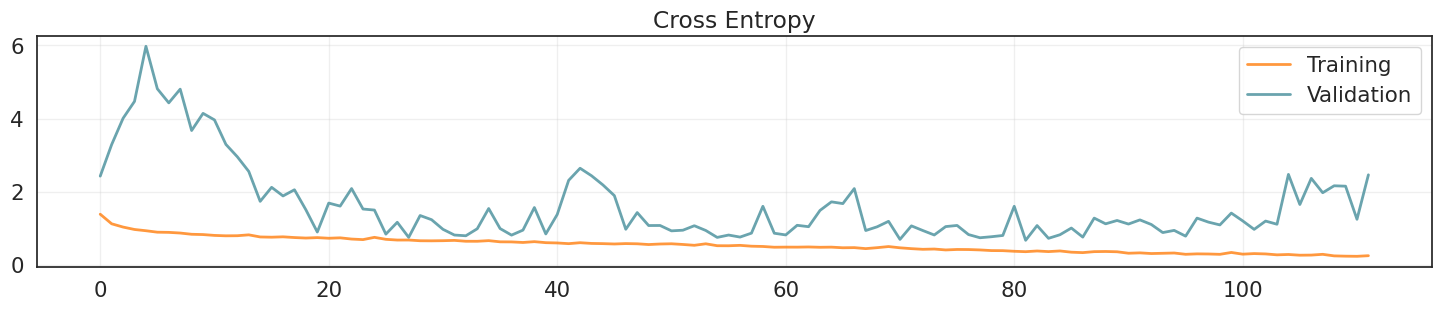

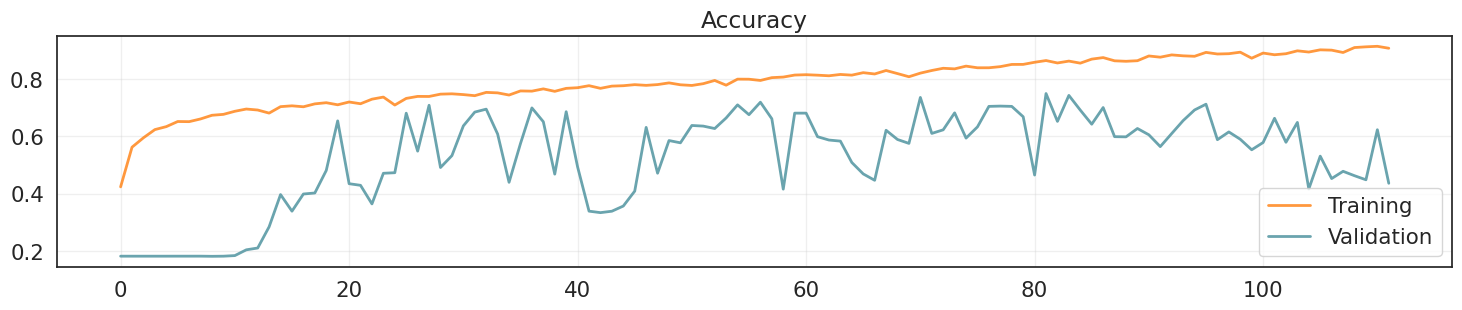

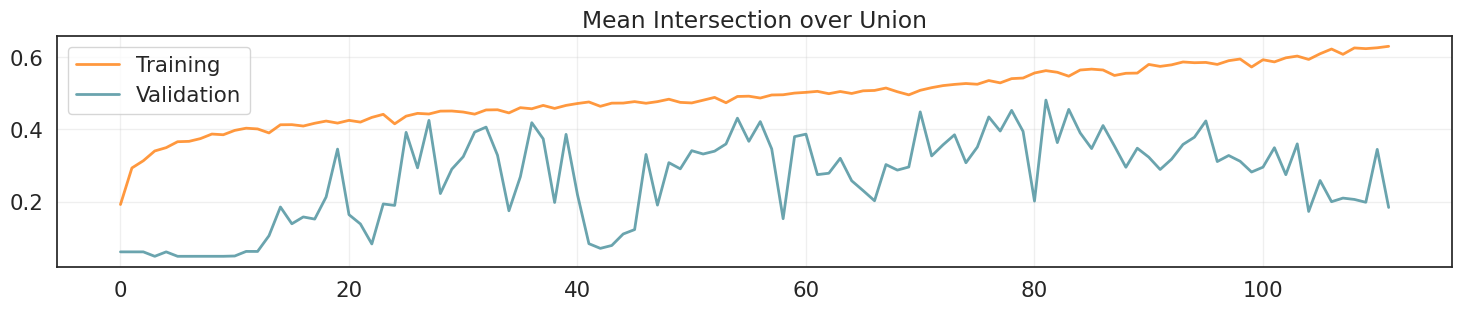

In [20]:
# Plot and display training and validation loss
plt.figure(figsize=(18, 3))
plt.plot(history['loss'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_loss'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Cross Entropy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation accuracy
plt.figure(figsize=(18, 3))
plt.plot(history['accuracy'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_accuracy'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Accuracy')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

# Plot and display training and validation mean IoU
plt.figure(figsize=(18, 3))
plt.plot(history['mean_iou'], label='Training', alpha=0.8, color='#ff7f0e', linewidth=2)
plt.plot(history['val_mean_iou'], label='Validation', alpha=0.9, color='#5a9aa5', linewidth=2)
plt.title('Mean Intersection over Union')
plt.legend()
plt.grid(alpha=0.3)
plt.show()

### Model predictions

In [ ]:
def y_to_df(y) -> pd.DataFrame:
    """Converts segmentation predictions into a DataFrame format for Kaggle."""
    n_samples = len(y)
    y_flat = y.reshape(n_samples, -1)
    df = pd.DataFrame(y_flat)
    df["id"] = np.arange(n_samples)
    cols = ["id"] + [col for col in df.columns if col != "id"]
    return df[cols]

def visualize_predictions(X_test, y_test, y_pred, num_samples=10):
    """
    Visualizza immagini, maschere ground truth e maschere predette.
    
    Args:
        X_test (numpy array): Immagini di test.
        y_test (numpy array): Maschere ground truth corrispondenti.
        y_pred (numpy array): Maschere predette dal modello.
        num_samples (int): Numero di campioni da visualizzare. Default è 5.
    """
    # Seleziona indici casuali per i campioni da visualizzare
    indices = random.sample(range(len(X_test)), num_samples)

    plt.figure(figsize=(15, num_samples * 3))

    for i, idx in enumerate(indices):
        # Immagine di test
        plt.subplot(num_samples, 3, i * 3 + 1)
        plt.imshow(X_test[idx], cmap='gray')
        plt.title("Test Image")
        plt.axis('off')

        # Maschera Ground Truth
        plt.subplot(num_samples, 3, i * 3 + 2)
        plt.imshow(y_test[idx], cmap='gray')
        plt.title("Ground Truth Mask")
        plt.axis('off')

        # Maschera Predetta
        plt.subplot(num_samples, 3, i * 3 + 3)
        plt.imshow(y_pred[idx], cmap='gray')
        plt.title("Predicted Mask")
        plt.axis('off')

    plt.tight_layout()
    plt.show()

def calculate_confusion_matrix(y_true, y_pred, num_classes):
    """
    Calcola la matrice di confusione a livello di pixel per il task di segmentazione semantica.

    Args:
        y_true (numpy array): Ground truth (maschere di verità a livello di pixel).
        y_pred (numpy array): Maschere predette dal modello.
        num_classes (int): Numero di classi.

    Returns:
        numpy array: Matrice di confusione.
    """
    # Appiattisci le maschere (da 2D a 1D) per calcolare la matrice di confusione
    y_true_flat = y_true.flatten()
    y_pred_flat = y_pred.flatten()

    # Calcola la matrice di confusione
    cm = confusion_matrix(y_true_flat, y_pred_flat, labels=np.arange(num_classes))
    return cm

def plot_confusion_matrix(cm, class_names):
    """
    Visualizza la matrice di confusione con una heatmap.

    Args:
        cm (numpy array): Matrice di confusione.
        class_names (list): Nomi delle classi.
    """
    plt.figure(figsize=(8, 6))
    disp = ConfusionMatrixDisplay(confusion_matrix=cm, display_labels=class_names)
    disp.plot(cmap='Blues', values_format='d')
    plt.title("Confusion Matrix")
    plt.show()

In [ ]:
preds = model.predict(X_test)  #/255.0 was already done at the beginning
preds = np.argmax(preds, axis=-1)
print(f"Predictions shape: {preds.shape}")

# Create and download the csv submission file
timestep_str = model_filename.replace("model_", "").replace(".keras", "")
submission_filename = f"submission_{timestep_str}.csv"
submission_df = y_to_df(preds)
submission_df.to_csv(submission_filename, index=False)

In [ ]:
preds = model.predict(X_train_val)
y_pred_resized = np.argmax(preds, axis=-1)  
visualize_predictions(X_train_val, y_train_val, y_pred_resized)

In [ ]:
y_pred = np.argmax(preds, axis=-1)

# Calcola la matrice di confusione
cm = calculate_confusion_matrix(y_train_val, y_pred, num_classes)


# Visualizza la matrice di confusione
class_names = ["Background", "Soil", "Bedrock", "Sand", "Big Rock"]  # Modifica i nomi delle classi se necessario
plot_confusion_matrix(cm, class_names)

# Calcolo metriche utili (opzionale)
pixel_accuracy = np.trace(cm) / np.sum(cm)  # Accuratezza totale sui pixel
print(f"Pixel Accuracy: {pixel_accuracy:.2%}")

# Per ogni classe
iou_per_class = np.diag(cm) / (cm.sum(axis=1) + cm.sum(axis=0) - np.diag(cm))
print(f"IoU per classe: {dict(zip(class_names, iou_per_class))}")
print(f"Mean IoU: {np.mean(iou_per_class):.2%}")